In [1]:
!pip install deepspeed
!pip install lightning
!pip install torchmetrics
!pip install torch-fidelity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | / - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.6 MB/s eta 0:00:00
  Created wheel for deepspeed: filename=deepspeed-0.16.3-py3-none-any.whl size=1550058 sha256=a352eb49ed1d2ed566e5a7d1518aadd1ff8ecd9005a2dd329c4c00fe09a96218
  Stored in directory: /root/.cache/pip/wheels/ca/e2/8f/3a91068b57481b104c9c450a20239ec874f6141f8b3769e0dd
Successfully built deepspeed
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.9 MB/s eta 0:00:00


In [2]:
import glob
import os
import shutil

import deepspeed as ds
import matplotlib.pyplot as plt
import numpy as np
import lightning as L
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from lightning.pytorch.utilities.combined_loader import CombinedLoader
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.utils import make_grid, save_image

_ = L.seed_everything(0, workers=True)

[2025-01-30 19:00:43,024] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
INFO: Seed set to 0


# Show Image Function

In [3]:
def show_img(img_tensor, nrow, title=""):
    img_tensor = img_tensor.detach().cpu() * 0.5 + 0.5
    img_grid = make_grid(img_tensor, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=(18, 8))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Image Augmentation

In [4]:
class CustomTransform(object):
    def __init__(self, load_dim=286, target_dim=256):
        self.transform_train = T.Compose([
            T.Resize((load_dim, load_dim), antialias=True),
            T.RandomCrop((target_dim, target_dim)),
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.2, contrast=0.2,
                          saturation=0.2, hue=0.1),
        ])
        
        # ensure images outside of training dataset are also of the same size
        self.transform = T.Resize((target_dim, target_dim), antialias=True)
        
    def __call__(self, img, stage):
        if stage == "fit":
            img = self.transform_train(img)
        else:
            img = self.transform(img)
        return img * 2 - 1

# Custom Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, filenames, transform, stage):
        self.filenames = filenames
        self.transform = transform
        self.stage = stage
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img = read_image(img_name) / 255.0
        return self.transform(img, stage=self.stage)

In [6]:
# change to True to set the configuration for debugging mode
DEBUG = False
# DEBUG = True

DM_CONFIG = {    
    # the directories where the Monet paintings and photos are loaded from
    "train_mri_dir": os.path.join("/kaggle/input/mri-ct/mri-ct_resized_lanczos/train/mri", "*.png"),
    "train_ct_dir": os.path.join("/kaggle/input/mri-ct/mri-ct_resized_lanczos/train/ct", "*.png"),
    "valid_mri_dir": os.path.join("/kaggle/input/mri-ct/mri-ct_resized_lanczos/val/mri", "*.png"),
    "valid_ct_dir": os.path.join("/kaggle/input/mri-ct/mri-ct_resized_lanczos/val/ct", "*.png"),
    
    "loader_config": {
        # the number of subprocesses (excluding the main process) used for data loading
        "num_workers": os.cpu_count(),
        
        # enable faster data transfer to GPU during training
        "pin_memory": torch.cuda.is_available(),
    },
    
    # the validation/test batch size (mainly for visualization purposes)
    "sample_size": 5,
    
    # the training/prediction batch size
    "batch_size": 32,
}

In [7]:
class CustomDataModule(L.LightningDataModule):
    def __init__(
        self,
        train_mri_dir,
        train_ct_dir,
        valid_mri_dir,
        valid_ct_dir,
        loader_config,
        sample_size,
        batch_size,
    ):
        super().__init__()
        self.loader_config = loader_config
        self.sample_size = sample_size
        self.batch_size = batch_size       
            
        # store file paths
        self.train_mri_filenames = sorted(glob.glob(train_mri_dir))
        self.train_ct_filenames = sorted(glob.glob(train_ct_dir))
        self.valid_mri_filenames = sorted(glob.glob(valid_mri_dir))
        self.valid_ct_filenames = sorted(glob.glob(valid_ct_dir))
        
        # define transformations for image augmentation
        self.transform = CustomTransform()
        
    def setup(self, stage):
        if stage == "fit":
            self.train_mri = CustomDataset(self.train_mri_filenames, self.transform, stage)
            self.train_ct = CustomDataset(self.train_ct_filenames, self.transform, stage)            
            
        if stage in ["fit", "test", "predict"]:
            # to be used for test and prediction datasets as well
            self.valid_mri = CustomDataset(self.valid_mri_filenames, self.transform, None)
            self.valid_ct = CustomDataset(self.valid_ct_filenames, self.transform, None)
            
    def train_dataloader(self):
        loader_config = {
            "shuffle": True,
            "drop_last": False,
            "batch_size": self.batch_size,
            **self.loader_config,
        }
        loader_mri = DataLoader(self.train_mri, **loader_config)
        loader_ct = DataLoader(self.train_ct, **loader_config)
        loaders = {"mri": loader_mri, "ct": loader_ct}
        return CombinedLoader(loaders, mode="max_size_cycle")
    
    def val_dataloader(self):
        return DataLoader(
            self.valid_ct,
            batch_size=self.sample_size,
            **self.loader_config,
        )
    
    def test_dataloader(self):
        return self.val_dataloader()
    
    def predict_dataloader(self):
        return DataLoader(
            self.valid_ct,
            batch_size=self.batch_size,
            **self.loader_config,
        )

    def get_real_img_loader(self):
        return DataLoader(
            self.valid_mri,
            batch_size=self.batch_size,
            **self.loader_config,
        )
        

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


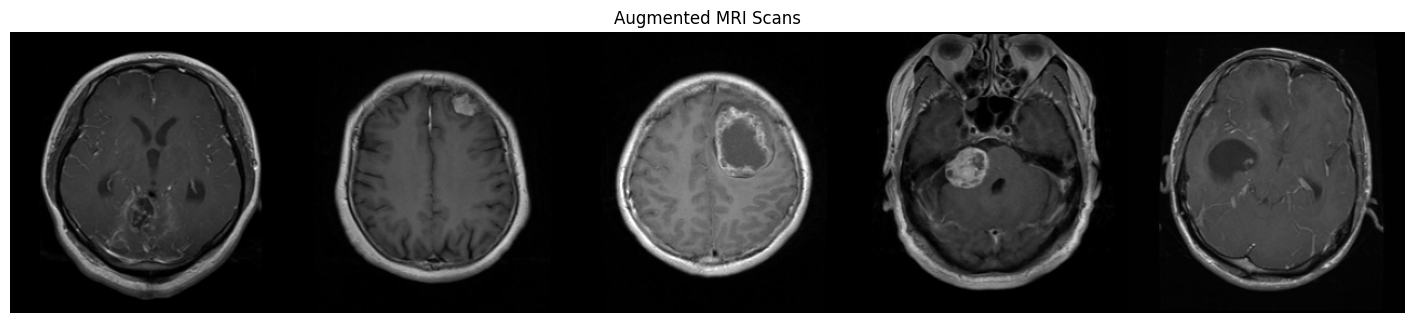

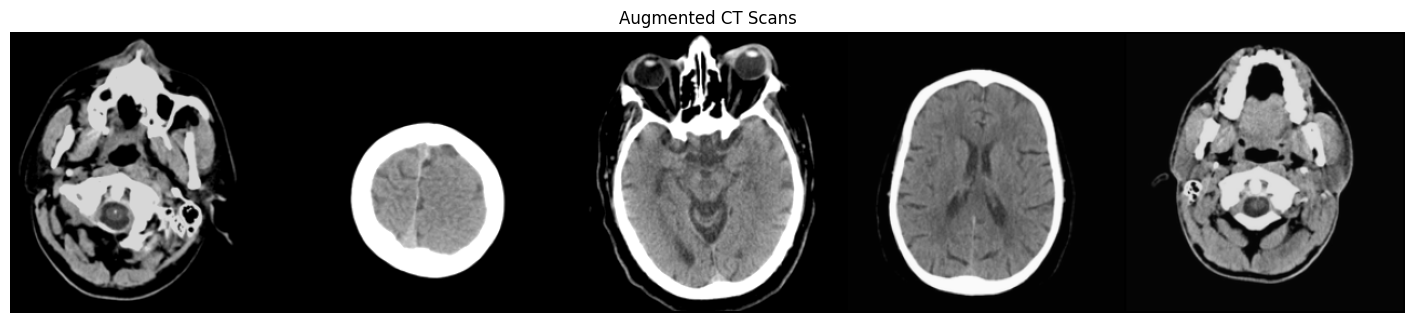

In [8]:
dm_sample = CustomDataModule(batch_size=5, **{k: v for k, v in DM_CONFIG.items() if k != "batch_size"})
dm_sample.setup("fit")

train_loader = dm_sample.train_dataloader()
imgs = next(iter(train_loader))


show_img(imgs[0]["mri"], nrow=5, title="Augmented MRI Scans")
show_img(imgs[0]["ct"], nrow=5, title="Augmented CT Scans")

In [9]:
class Downsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        norm=True,
        lrelu=True,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=not norm),
        )
        if norm:
            self.block.append(nn.InstanceNorm2d(out_channels, affine=True))
        if lrelu is not None:
            self.block.append(nn.LeakyReLU(0.2, True) if lrelu else nn.ReLU(True))
        
    def forward(self, x):
        return self.block(x)

In [10]:
class Upsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        output_padding=0,
        dropout=False,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels,
                               kernel_size=kernel_size, stride=stride, 
                               padding=padding, output_padding=output_padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
        )
        if dropout:
            self.block.append(nn.Dropout(0.5))
        self.block.append(nn.ReLU(True))
        
    def forward(self, x):
        return self.block(x)

In [11]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, kernel_size=3, padding=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(padding),
            Downsampling(in_channels, in_channels,
                         kernel_size=kernel_size, stride=1, padding=0, lrelu=False),
            nn.ReflectionPad2d(padding),
            Downsampling(in_channels, in_channels,
                         kernel_size=kernel_size, stride=1, padding=0, lrelu=None),
        )
        
    def forward(self, x):
        return x + self.block(x)

In [12]:
class UNetGenerator(nn.Module):
    def __init__(self, hid_channels, in_channels, out_channels):
        super().__init__()
        self.downsampling_path = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), # 64x128x128
            Downsampling(hid_channels, hid_channels*2), # 128x64x64
            Downsampling(hid_channels*2, hid_channels*4), # 256x32x32
            Downsampling(hid_channels*4, hid_channels*8), # 512x16x16
            Downsampling(hid_channels*8, hid_channels*8), # 512x8x8
            Downsampling(hid_channels*8, hid_channels*8), # 512x4x4
            Downsampling(hid_channels*8, hid_channels*8), # 512x2x2
            Downsampling(hid_channels*8, hid_channels*8, norm=False), # 512x1x1, instance norm does not work on 1x1
        )
        self.upsampling_path = nn.Sequential(
            Upsampling(hid_channels*8, hid_channels*8, dropout=True), # (512+512)x2x2
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), # (512+512)x4x4
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), # (512+512)x8x8
            Upsampling(hid_channels*16, hid_channels*8), # (512+512)x16x16
            Upsampling(hid_channels*16, hid_channels*4), # (256+256)x32x32
            Upsampling(hid_channels*8, hid_channels*2), # (128+128)x64x64
            Upsampling(hid_channels*4, hid_channels), # (64+64)x128x128
        )
        self.feature_block = nn.Sequential(
            nn.ConvTranspose2d(hid_channels*2, out_channels,
                               kernel_size=4, stride=2, padding=1), # 3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        skips = []
        for down in self.downsampling_path:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])

        for up, skip in zip(self.upsampling_path, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)
        return self.feature_block(x)
    
class ResNetGenerator(nn.Module):
    def __init__(self, hid_channels, in_channels, out_channels, num_resblocks):
        super().__init__()
        self.model = nn.Sequential(
            # downsampling path
            nn.ReflectionPad2d(3),
            Downsampling(in_channels, hid_channels,
                         kernel_size=7, stride=1, padding=0, lrelu=False), # 64x256x256
            Downsampling(hid_channels, hid_channels*2, kernel_size=3, lrelu=False), # 128x128x128
            Downsampling(hid_channels*2, hid_channels*4, kernel_size=3, lrelu=False), # 256x64x64
            
            # residual blocks
            *[ResBlock(hid_channels*4) for _ in range(num_resblocks)], # 256x64x64
            
            # upsampling path
            Upsampling(hid_channels*4, hid_channels*2, kernel_size=3, output_padding=1), # 128x128x128
            Upsampling(hid_channels*2, hid_channels, kernel_size=3, output_padding=1), # 64x256x256
            nn.ReflectionPad2d(3),
            nn.Conv2d(hid_channels, out_channels, kernel_size=7, stride=1, padding=0), # 3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.model(x)
    
def get_gen(gen_name, hid_channels, num_resblocks, in_channels=3, out_channels=3):
    if gen_name == "unet":
        return UNetGenerator(hid_channels, in_channels, out_channels)
    elif gen_name == "resnet":
        return ResNetGenerator(hid_channels, in_channels, out_channels, num_resblocks)
    else:
        raise NotImplementedError(f"Generator name '{gen_name}' not recognized.")

In [13]:
class Discriminator(nn.Module):
    def __init__(self, hid_channels, in_channels=3):
        super().__init__()
        self.block = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), # 64x128x128
            Downsampling(hid_channels, hid_channels*2), # 128x64x64
            Downsampling(hid_channels*2, hid_channels*4), # 256x32x32
            Downsampling(hid_channels*4, hid_channels*8, stride=1), # 512x31x31
            nn.Conv2d(hid_channels*8, 1, kernel_size=4, padding=1), # 1x30x30
        )
        
    def forward(self, x):
        return self.block(x)

In [14]:
# adapted from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/util/image_pool.py
class ImageBuffer(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        if self.buffer_size > 0:
            # the current capacity of the buffer
            self.curr_cap = 0
            # initialize buffer as empty list
            self.buffer = []
    
    def __call__(self, imgs):
        # the buffer is not used
        if self.buffer_size == 0:
            return imgs
        
        return_imgs = []
        for img in imgs:
            img = img.unsqueeze(dim=0)
            
            # fill buffer to maximum capacity
            if self.curr_cap < self.buffer_size:
                self.curr_cap += 1
                self.buffer.append(img)
                return_imgs.append(img)
            else:
                p = np.random.uniform(low=0., high=1.)
                
                # swap images between input and buffer with probability 0.5
                if p > 0.5:
                    idx = np.random.randint(low=0, high=self.buffer_size)
                    tmp = self.buffer[idx].clone()
                    self.buffer[idx] = img
                    return_imgs.append(tmp)
                else:
                    return_imgs.append(img)
        return torch.cat(return_imgs, dim=0)

In [15]:
MODEL_CONFIG = {
    # the type of generator, and the number of residual blocks if ResNet generator is used
    "gen_name": "unet", # types: 'unet', 'resnet'
    "num_resblocks": 6,
    
    # the number of filters in the first layer for the generators and discriminators
    "hid_channels": 64,
    
    # using DeepSpeed's FusedAdam (currently GPU only) is slightly faster
    "optimizer": ds.ops.adam.FusedAdam if torch.cuda.is_available() else torch.optim.Adam,
    
    # the learning rate and beta parameters for the Adam optimizer
    "lr": 2e-4,
    "betas": (0.5, 0.999),
    
    # the weights used in the identity loss and cycle loss
    "lambda_idt": 0.5,
    "lambda_cycle": (10, 10), # (MPM direction, PMP direction)
    
    # the size of the buffer that stores previously generated images
    "buffer_size": 100,
    
    # the number of epochs for training
    "num_epochs": 300 if not DEBUG else 2, # mainly 300
    
    # the number of epochs before starting the learning rate decay
    "decay_epochs": 20 if not DEBUG else 1,
}

In [16]:
class CycleGAN(L.LightningModule):
    def __init__(
        self,
        gen_name,
        num_resblocks,
        hid_channels,
        optimizer,
        lr,
        betas,
        lambda_idt,
        lambda_cycle,
        buffer_size,
        num_epochs,
        decay_epochs,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.optimizer = optimizer
        self.automatic_optimization = False
        
        # define generators and discriminators
        self.gen_CT_MRI = get_gen(gen_name, hid_channels, num_resblocks)
        self.gen_MRI_CT = get_gen(gen_name, hid_channels, num_resblocks)
        self.disc_MRI = Discriminator(hid_channels)
        self.disc_CT = Discriminator(hid_channels)
        
        # initialize buffers to store fake images
        self.buffer_fake_MRI = ImageBuffer(buffer_size)
        self.buffer_fake_CT = ImageBuffer(buffer_size)
        
    
    def forward(self, img):
        return self.gen_CT_MRI(img)        
            
    def init_weights(self):
        def init_fn(m):
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.InstanceNorm2d)):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
        
        for net in [self.gen_CT_MRI, self.gen_MRI_CT, self.disc_MRI, self.disc_CT]:
            net.apply(init_fn)
        
    def setup(self, stage):
        if stage == "fit":
            self.init_weights()
            print("Model initialized.")
            
    def get_lr_scheduler(self, optimizer):
        def lr_lambda(epoch):
            len_decay_phase = self.hparams.num_epochs - self.hparams.decay_epochs + 1.0
            curr_decay_step = max(0, epoch - self.hparams.decay_epochs + 1.0)
            val = 1.0 - curr_decay_step / len_decay_phase
            return max(0.0, val)
        
        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    
    def configure_optimizers(self):
        opt_config = {
            "lr": self.hparams.lr,
            "betas": self.hparams.betas,
        }
        opt_gen = self.optimizer(
            list(self.gen_CT_MRI.parameters()) + list(self.gen_MRI_CT.parameters()),
            **opt_config,
        )
        opt_disc = self.optimizer(
            list(self.disc_MRI.parameters()) + list(self.disc_CT.parameters()),
            **opt_config,
        )
        optimizers = [opt_gen, opt_disc]
        schedulers = [self.get_lr_scheduler(opt) for opt in optimizers]
        return optimizers, schedulers
        
    def adv_criterion(self, y_hat, y):
        return F.mse_loss(y_hat, y)
    
    def recon_criterion(self, y_hat, y):
        return F.l1_loss(y_hat, y)
    
    def get_adv_loss(self, fake, disc):
        fake_hat = disc(fake)
        real_labels = torch.ones_like(fake_hat)
        adv_loss = self.adv_criterion(fake_hat, real_labels)
        return adv_loss
    
    def get_idt_loss(self, real, idt, lambda_cycle):
        idt_loss = self.recon_criterion(idt, real)
        return self.hparams.lambda_idt * lambda_cycle * idt_loss
    
    def get_cycle_loss(self, real, recon, lambda_cycle):
        cycle_loss = self.recon_criterion(recon, real)
        return lambda_cycle * cycle_loss
    
    def get_gen_loss(self):
        # calculate adversarial loss
        adv_loss_CT_MRI = self.get_adv_loss(self.fake_MRI, self.disc_MRI)
        adv_loss_MRI_CT = self.get_adv_loss(self.fake_CT, self.disc_CT)
        total_adv_loss = adv_loss_CT_MRI + adv_loss_MRI_CT
        
        # calculate identity loss
        lambda_cycle = self.hparams.lambda_cycle
        idt_loss_MRI_MRI = self.get_idt_loss(self.real_MRI, self.idt_MRI, lambda_cycle[0])
        idt_loss_CT_CT = self.get_idt_loss(self.real_CT, self.idt_CT, lambda_cycle[1])
        total_idt_loss = idt_loss_MRI_MRI + idt_loss_CT_CT
        
        # calculate cycle loss
        cycle_loss_MRI_CT_MRI = self.get_cycle_loss(self.real_MRI, self.recon_MRI, lambda_cycle[0])
        cycle_loss_CT_MRI_CT = self.get_cycle_loss(self.real_CT, self.recon_CT, lambda_cycle[1])
        total_cycle_loss = cycle_loss_MRI_CT_MRI + cycle_loss_CT_MRI_CT
        
        # combine losses
        gen_loss = total_adv_loss + total_idt_loss + total_cycle_loss
        return gen_loss
    
    def get_disc_loss(self, real, fake, disc):
        # calculate loss on real images
        real_hat = disc(real)
        real_labels = torch.ones_like(real_hat)
        real_loss = self.adv_criterion(real_hat, real_labels)
        
        # calculate loss on fake images
        fake_hat = disc(fake.detach())
        fake_labels = torch.zeros_like(fake_hat)
        fake_loss = self.adv_criterion(fake_hat, fake_labels)
        
        # combine losses
        disc_loss = (fake_loss + real_loss) * 0.5
        return disc_loss
    
    def get_disc_loss_MRI(self):
        fake_MRI = self.buffer_fake_MRI(self.fake_MRI)
        return self.get_disc_loss(self.real_MRI, fake_MRI, self.disc_MRI)
    
    def get_disc_loss_CT(self):
        fake_CT = self.buffer_fake_CT(self.fake_CT)
        return self.get_disc_loss(self.real_CT, fake_CT, self.disc_CT)
    
    def training_step(self, batch, batch_idx):
        self.real_MRI = batch["mri"]
        self.real_CT = batch["ct"]
        opt_gen, opt_disc = self.optimizers()

        # generate fake images
        self.fake_MRI = self.gen_CT_MRI(self.real_CT)
        self.fake_CT = self.gen_MRI_CT(self.real_MRI)
        
        # generate identity images
        self.idt_MRI = self.gen_CT_MRI(self.real_MRI)
        self.idt_CT = self.gen_MRI_CT(self.real_CT)
        
        # reconstruct images
        self.recon_MRI = self.gen_CT_MRI(self.fake_CT)
        self.recon_CT = self.gen_MRI_CT(self.fake_MRI)
    
        # train generators
        self.toggle_optimizer(opt_gen)
        gen_loss = self.get_gen_loss()        
        opt_gen.zero_grad()
        self.manual_backward(gen_loss)
        opt_gen.step()
        self.untoggle_optimizer(opt_gen)
        
        # train discriminators
        self.toggle_optimizer(opt_disc)
        disc_loss_MRI = self.get_disc_loss_MRI()
        disc_loss_CT = self.get_disc_loss_CT()
        opt_disc.zero_grad()
        self.manual_backward(disc_loss_MRI)
        self.manual_backward(disc_loss_CT)
        opt_disc.step()
        self.untoggle_optimizer(opt_disc)
        
        # record training losses
        metrics = {
            "gen_loss": gen_loss,
            "disc_loss_MRI": disc_loss_MRI,
            "disc_loss_CT": disc_loss_CT,
        }
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
        
    def validation_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "validate")
    
    def test_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "test")
        
    def predict_step(self, batch, batch_idx):
        return self(batch)
    
    def display_results(self, batch, batch_idx, stage):
        real_CT = batch
        fake_MRI = self(real_CT)
        
        if stage == "validate":
            title = f"Epoch {self.current_epoch+1}: CT-to-MRI Translation"
        else:
            title = f"Sample {batch_idx+1}: CT-to-MRI Translation"

        show_img(
            torch.cat([real_CT, fake_MRI], dim=0),
            nrow=len(real_CT),
            title=title,
        )
    
    def on_train_epoch_start(self):
        # record learning rates
        curr_lr = self.lr_schedulers()[0].get_last_lr()[0]
        self.log("lr", curr_lr, on_step=False, on_epoch=True, prog_bar=True)
        
    def on_train_epoch_end(self):
        # update learning rates
        for sch in self.lr_schedulers():
            sch.step()
        
        # print current state of epoch
        logged_values = self.trainer.progress_bar_metrics
        print(
            f"Epoch {self.current_epoch+1}",
            *[f"{k}: {v:.5f}" for k, v in logged_values.items()],
            sep=" - ",
        )
        
    def on_train_end(self):
        print("Training ended.")
        
    def on_predict_epoch_end(self):
        predictions = self.trainer.predict_loop.predictions
        num_batches = len(predictions)
        batch_size = predictions[0].shape[0]
        last_batch_diff = batch_size - predictions[-1].shape[0]
        print(f"Number of images generated: {num_batches*batch_size-last_batch_diff}.")

In [17]:
TRAIN_CONFIG = {
    "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
    
    # train on 16-bit precision
    "precision": "16-mixed" if torch.cuda.is_available() else 32,
    
    # train on multi GPU
    "devices": [1],
    
    # save checkpoint only for last epoch by default
    "enable_checkpointing": True,
    
    # disable logging for simplicity
    "logger": False,    
    
    # the number of epochs for training (we limit the number of train/predict batches during debugging)
    "max_epochs": MODEL_CONFIG["num_epochs"],
    "limit_train_batches": 1.0 if not DEBUG else 2,
    "limit_predict_batches": 1.0,
    
    # the maximum amount of time for training, in case we exceed run-time of 5 hours
    # "max_time": {"hours": 4, "minutes": 55},
    
    # use a small subset of photos for validation/testing (we limit here for flexibility)
    "limit_val_batches": 1,
    "limit_test_batches": 2,
    
    # disable sanity check before starting the training routine
    "num_sanity_val_steps": 0,
    
    # the frequency to visualize the progress of adding Monet style
    "check_val_every_n_epoch": MODEL_CONFIG["num_epochs"] if not DEBUG else 1,

    # disable progress bar
    "enable_progress_bar": False
}

In [18]:
main_folder = f'/kaggle/working/{MODEL_CONFIG["gen_name"]}_ct_mri'
ckpt_folder = main_folder
img_gen_foler = f'{main_folder}/gen'
os.makedirs(main_folder, exist_ok=True)
os.makedirs(ckpt_folder, exist_ok=True)
os.makedirs(img_gen_foler, exist_ok=True)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO: `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO: `Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Model initialized.


Using /root/.cache/torch_extensions/py310_cu123 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu123/fused_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu123/fused_adam/build.ninja...
/opt/conda/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module fused_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output multi_tensor_adam.cuda.o.d -DTORCH_EXTENSION_NAME=fused_adam -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/opt/conda/lib/python3.10/site-packages/deepspeed/ops/csrc/includes -I/opt/conda/lib/python3.10/site-packages/deepspeed/ops/csrc/adam -isystem /opt/conda/lib/python3.10/site-packages/torch/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/TH -isystem /opt/conda/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /opt/conda/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=1 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_75,code=compute_75 -gencod

Loading extension module fused_adam...
INFO: 
  | Name       | Type          | Params | Mode 
-----------------------------------------------------
0 | gen_CT_MRI | UNetGenerator | 54.4 M | train
1 | gen_MRI_CT | UNetGenerator | 54.4 M | train
2 | disc_MRI   | Discriminator | 2.8 M  | train
3 | disc_CT    | Discriminator | 2.8 M  | train
-----------------------------------------------------
114 M     Trainable params
0         Non-trainable params
114 M     Total params
457.441   Total estimated model params size (MB)
208       Modules in train mode
0         Modules in eval mode


[3/3] c++ fused_adam_frontend.o multi_tensor_adam.cuda.o -shared -L/opt/conda/lib/python3.10/site-packages/torch/lib -lc10 -lc10_cuda -ltorch_cpu -ltorch_cuda -ltorch -ltorch_python -L/usr/local/cuda/lib64 -lcudart -o fused_adam.so
Time to load fused_adam op: 33.270851850509644 seconds


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 1 - lr: 0.00020 - gen_loss: 14.00303 - disc_loss_MRI: 0.21606 - disc_loss_CT: 0.22320


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 2 - lr: 0.00020 - gen_loss: 4.61362 - disc_loss_MRI: 0.04872 - disc_loss_CT: 0.06029


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 3 - lr: 0.00020 - gen_loss: 3.97201 - disc_loss_MRI: 0.06411 - disc_loss_CT: 0.09235


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 4 - lr: 0.00020 - gen_loss: 3.64639 - disc_loss_MRI: 0.10682 - disc_loss_CT: 0.11725


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 5 - lr: 0.00020 - gen_loss: 3.46330 - disc_loss_MRI: 0.11659 - disc_loss_CT: 0.11127


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 6 - lr: 0.00020 - gen_loss: 3.43849 - disc_loss_MRI: 0.11983 - disc_loss_CT: 0.10227


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 7 - lr: 0.00020 - gen_loss: 3.42495 - disc_loss_MRI: 0.12669 - disc_loss_CT: 0.10796


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 8 - lr: 0.00020 - gen_loss: 3.41518 - disc_loss_MRI: 0.13196 - disc_loss_CT: 0.11386


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 9 - lr: 0.00020 - gen_loss: 3.30731 - disc_loss_MRI: 0.13968 - disc_loss_CT: 0.11230


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 10 - lr: 0.00020 - gen_loss: 3.17656 - disc_loss_MRI: 0.14518 - disc_loss_CT: 0.12225


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 11 - lr: 0.00020 - gen_loss: 3.16764 - disc_loss_MRI: 0.14570 - disc_loss_CT: 0.13960


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 12 - lr: 0.00020 - gen_loss: 3.09026 - disc_loss_MRI: 0.14356 - disc_loss_CT: 0.12160


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 13 - lr: 0.00020 - gen_loss: 3.10428 - disc_loss_MRI: 0.14127 - disc_loss_CT: 0.12972


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 14 - lr: 0.00020 - gen_loss: 3.09371 - disc_loss_MRI: 0.13378 - disc_loss_CT: 0.12760


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 15 - lr: 0.00020 - gen_loss: 2.97493 - disc_loss_MRI: 0.14404 - disc_loss_CT: 0.13105


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 16 - lr: 0.00020 - gen_loss: 3.02672 - disc_loss_MRI: 0.15581 - disc_loss_CT: 0.12994


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 17 - lr: 0.00020 - gen_loss: 2.88970 - disc_loss_MRI: 0.13983 - disc_loss_CT: 0.14050


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 18 - lr: 0.00020 - gen_loss: 2.92099 - disc_loss_MRI: 0.14752 - disc_loss_CT: 0.13638


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 19 - lr: 0.00020 - gen_loss: 3.00768 - disc_loss_MRI: 0.16298 - disc_loss_CT: 0.12984


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 20 - lr: 0.00020 - gen_loss: 2.84378 - disc_loss_MRI: 0.13959 - disc_loss_CT: 0.12869


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 21 - lr: 0.00020 - gen_loss: 2.90707 - disc_loss_MRI: 0.14164 - disc_loss_CT: 0.13315


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 22 - lr: 0.00020 - gen_loss: 2.88152 - disc_loss_MRI: 0.14117 - disc_loss_CT: 0.13221


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 23 - lr: 0.00020 - gen_loss: 2.84803 - disc_loss_MRI: 0.14971 - disc_loss_CT: 0.12273


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 24 - lr: 0.00020 - gen_loss: 2.79099 - disc_loss_MRI: 0.14092 - disc_loss_CT: 0.12961


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 25 - lr: 0.00020 - gen_loss: 2.92509 - disc_loss_MRI: 0.13789 - disc_loss_CT: 0.11592


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 26 - lr: 0.00020 - gen_loss: 2.81717 - disc_loss_MRI: 0.14064 - disc_loss_CT: 0.13014


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 27 - lr: 0.00020 - gen_loss: 2.83602 - disc_loss_MRI: 0.14448 - disc_loss_CT: 0.12906


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 28 - lr: 0.00019 - gen_loss: 2.80295 - disc_loss_MRI: 0.13776 - disc_loss_CT: 0.12921


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 29 - lr: 0.00019 - gen_loss: 2.81588 - disc_loss_MRI: 0.14981 - disc_loss_CT: 0.11724


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 30 - lr: 0.00019 - gen_loss: 2.76185 - disc_loss_MRI: 0.13948 - disc_loss_CT: 0.14640


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 31 - lr: 0.00019 - gen_loss: 2.79234 - disc_loss_MRI: 0.25938 - disc_loss_CT: 0.12415


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 32 - lr: 0.00019 - gen_loss: 2.46319 - disc_loss_MRI: 0.23360 - disc_loss_CT: 0.12853


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 33 - lr: 0.00019 - gen_loss: 2.46585 - disc_loss_MRI: 0.20873 - disc_loss_CT: 0.13492


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 34 - lr: 0.00019 - gen_loss: 2.58909 - disc_loss_MRI: 0.16630 - disc_loss_CT: 0.17310


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 35 - lr: 0.00019 - gen_loss: 2.71511 - disc_loss_MRI: 0.14482 - disc_loss_CT: 0.12066


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 36 - lr: 0.00019 - gen_loss: 2.69889 - disc_loss_MRI: 0.14480 - disc_loss_CT: 0.12786


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 37 - lr: 0.00019 - gen_loss: 2.68368 - disc_loss_MRI: 0.14827 - disc_loss_CT: 0.13031


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 38 - lr: 0.00019 - gen_loss: 2.75384 - disc_loss_MRI: 0.14132 - disc_loss_CT: 0.11629


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 39 - lr: 0.00019 - gen_loss: 2.69068 - disc_loss_MRI: 0.14402 - disc_loss_CT: 0.14793


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 40 - lr: 0.00019 - gen_loss: 2.64126 - disc_loss_MRI: 0.14406 - disc_loss_CT: 0.12280


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 41 - lr: 0.00019 - gen_loss: 2.64663 - disc_loss_MRI: 0.15502 - disc_loss_CT: 0.13439


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 42 - lr: 0.00018 - gen_loss: 2.77087 - disc_loss_MRI: 0.13025 - disc_loss_CT: 0.13870


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 43 - lr: 0.00018 - gen_loss: 2.71439 - disc_loss_MRI: 0.13804 - disc_loss_CT: 0.12628


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 44 - lr: 0.00018 - gen_loss: 2.76165 - disc_loss_MRI: 0.13579 - disc_loss_CT: 0.12692


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 45 - lr: 0.00018 - gen_loss: 2.82756 - disc_loss_MRI: 0.14617 - disc_loss_CT: 0.11625


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 46 - lr: 0.00018 - gen_loss: 2.73083 - disc_loss_MRI: 0.13640 - disc_loss_CT: 0.13940


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 47 - lr: 0.00018 - gen_loss: 2.72929 - disc_loss_MRI: 0.13415 - disc_loss_CT: 0.13876


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 48 - lr: 0.00018 - gen_loss: 2.71841 - disc_loss_MRI: 0.14391 - disc_loss_CT: 0.11993


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 49 - lr: 0.00018 - gen_loss: 2.74410 - disc_loss_MRI: 0.13608 - disc_loss_CT: 0.13569


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 50 - lr: 0.00018 - gen_loss: 2.67261 - disc_loss_MRI: 0.14398 - disc_loss_CT: 0.15163


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 51 - lr: 0.00018 - gen_loss: 2.64044 - disc_loss_MRI: 0.14814 - disc_loss_CT: 0.12650


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 52 - lr: 0.00018 - gen_loss: 2.70104 - disc_loss_MRI: 0.15461 - disc_loss_CT: 0.12724


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 53 - lr: 0.00018 - gen_loss: 2.67157 - disc_loss_MRI: 0.13998 - disc_loss_CT: 0.13577


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 54 - lr: 0.00018 - gen_loss: 2.65471 - disc_loss_MRI: 0.14984 - disc_loss_CT: 0.13071


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 55 - lr: 0.00018 - gen_loss: 2.77664 - disc_loss_MRI: 0.14328 - disc_loss_CT: 0.13882


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 56 - lr: 0.00017 - gen_loss: 2.60635 - disc_loss_MRI: 0.15141 - disc_loss_CT: 0.12938


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 57 - lr: 0.00017 - gen_loss: 2.68101 - disc_loss_MRI: 0.14144 - disc_loss_CT: 0.13316


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 58 - lr: 0.00017 - gen_loss: 2.64931 - disc_loss_MRI: 0.15068 - disc_loss_CT: 0.35987


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 59 - lr: 0.00017 - gen_loss: 2.15475 - disc_loss_MRI: 0.15090 - disc_loss_CT: 0.23469


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 60 - lr: 0.00017 - gen_loss: 2.10383 - disc_loss_MRI: 0.14347 - disc_loss_CT: 0.23104


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 61 - lr: 0.00017 - gen_loss: 2.12491 - disc_loss_MRI: 0.14964 - disc_loss_CT: 0.22941


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 62 - lr: 0.00017 - gen_loss: 2.12256 - disc_loss_MRI: 0.14771 - disc_loss_CT: 0.22375


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 63 - lr: 0.00017 - gen_loss: 2.15100 - disc_loss_MRI: 0.14670 - disc_loss_CT: 0.21799


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 64 - lr: 0.00017 - gen_loss: 2.16650 - disc_loss_MRI: 0.14294 - disc_loss_CT: 0.21315


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 65 - lr: 0.00017 - gen_loss: 2.19633 - disc_loss_MRI: 0.14797 - disc_loss_CT: 0.20916


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 66 - lr: 0.00017 - gen_loss: 2.27035 - disc_loss_MRI: 0.14385 - disc_loss_CT: 0.19750


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 67 - lr: 0.00017 - gen_loss: 2.27420 - disc_loss_MRI: 0.13261 - disc_loss_CT: 0.18815


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 68 - lr: 0.00017 - gen_loss: 2.34813 - disc_loss_MRI: 0.14089 - disc_loss_CT: 0.17989


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 69 - lr: 0.00017 - gen_loss: 2.31204 - disc_loss_MRI: 0.15523 - disc_loss_CT: 0.16534


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 70 - lr: 0.00016 - gen_loss: 2.35023 - disc_loss_MRI: 0.14841 - disc_loss_CT: 0.15456


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 71 - lr: 0.00016 - gen_loss: 2.43981 - disc_loss_MRI: 0.15391 - disc_loss_CT: 0.15063


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 72 - lr: 0.00016 - gen_loss: 2.43354 - disc_loss_MRI: 0.14621 - disc_loss_CT: 0.14343


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 73 - lr: 0.00016 - gen_loss: 2.60777 - disc_loss_MRI: 0.15821 - disc_loss_CT: 0.13342


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 74 - lr: 0.00016 - gen_loss: 2.58155 - disc_loss_MRI: 0.12625 - disc_loss_CT: 0.13284


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 75 - lr: 0.00016 - gen_loss: 2.60652 - disc_loss_MRI: 0.12722 - disc_loss_CT: 0.14441


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 76 - lr: 0.00016 - gen_loss: 2.60107 - disc_loss_MRI: 0.13485 - disc_loss_CT: 0.12626


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 77 - lr: 0.00016 - gen_loss: 2.50536 - disc_loss_MRI: 0.14764 - disc_loss_CT: 0.15704


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 78 - lr: 0.00016 - gen_loss: 2.50418 - disc_loss_MRI: 0.14439 - disc_loss_CT: 0.13421


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 79 - lr: 0.00016 - gen_loss: 2.51408 - disc_loss_MRI: 0.14560 - disc_loss_CT: 0.13116


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 80 - lr: 0.00016 - gen_loss: 2.49344 - disc_loss_MRI: 0.14693 - disc_loss_CT: 0.15371


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 81 - lr: 0.00016 - gen_loss: 2.56277 - disc_loss_MRI: 0.14396 - disc_loss_CT: 0.13233


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 82 - lr: 0.00016 - gen_loss: 2.46757 - disc_loss_MRI: 0.14903 - disc_loss_CT: 0.14135


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 83 - lr: 0.00016 - gen_loss: 2.50776 - disc_loss_MRI: 0.14716 - disc_loss_CT: 0.13157


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 84 - lr: 0.00015 - gen_loss: 2.49381 - disc_loss_MRI: 0.14344 - disc_loss_CT: 0.14618


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 85 - lr: 0.00015 - gen_loss: 2.50776 - disc_loss_MRI: 0.15170 - disc_loss_CT: 0.13934


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 86 - lr: 0.00015 - gen_loss: 2.49763 - disc_loss_MRI: 0.14525 - disc_loss_CT: 0.13368


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 87 - lr: 0.00015 - gen_loss: 2.48911 - disc_loss_MRI: 0.17544 - disc_loss_CT: 0.14457


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 88 - lr: 0.00015 - gen_loss: 2.52567 - disc_loss_MRI: 0.14316 - disc_loss_CT: 0.13453


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 89 - lr: 0.00015 - gen_loss: 2.52691 - disc_loss_MRI: 0.13894 - disc_loss_CT: 0.14106


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 90 - lr: 0.00015 - gen_loss: 2.36532 - disc_loss_MRI: 0.15469 - disc_loss_CT: 0.19858


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 91 - lr: 0.00015 - gen_loss: 2.45678 - disc_loss_MRI: 0.14107 - disc_loss_CT: 0.14235


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 92 - lr: 0.00015 - gen_loss: 2.48772 - disc_loss_MRI: 0.14109 - disc_loss_CT: 0.13624


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 93 - lr: 0.00015 - gen_loss: 2.71933 - disc_loss_MRI: 0.63473 - disc_loss_CT: 0.13530


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 94 - lr: 0.00015 - gen_loss: 2.36540 - disc_loss_MRI: 0.23689 - disc_loss_CT: 0.13651


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 95 - lr: 0.00015 - gen_loss: 2.22057 - disc_loss_MRI: 0.23543 - disc_loss_CT: 0.16866


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 96 - lr: 0.00015 - gen_loss: 2.14867 - disc_loss_MRI: 0.22440 - disc_loss_CT: 0.13602


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 97 - lr: 0.00015 - gen_loss: 2.25624 - disc_loss_MRI: 0.22008 - disc_loss_CT: 0.13126


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 98 - lr: 0.00014 - gen_loss: 2.23108 - disc_loss_MRI: 0.21201 - disc_loss_CT: 0.14583


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 99 - lr: 0.00014 - gen_loss: 2.24159 - disc_loss_MRI: 0.20374 - disc_loss_CT: 0.13711


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 100 - lr: 0.00014 - gen_loss: 2.24333 - disc_loss_MRI: 0.19568 - disc_loss_CT: 0.14887


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 101 - lr: 0.00014 - gen_loss: 2.36214 - disc_loss_MRI: 0.18628 - disc_loss_CT: 0.14038


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 102 - lr: 0.00014 - gen_loss: 2.29567 - disc_loss_MRI: 0.17943 - disc_loss_CT: 0.15531


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 103 - lr: 0.00014 - gen_loss: 2.30095 - disc_loss_MRI: 0.17448 - disc_loss_CT: 0.14284


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 104 - lr: 0.00014 - gen_loss: 2.71176 - disc_loss_MRI: 0.13018 - disc_loss_CT: 0.13374


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 105 - lr: 0.00014 - gen_loss: 2.44623 - disc_loss_MRI: 0.15290 - disc_loss_CT: 0.13119


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 106 - lr: 0.00014 - gen_loss: 2.41014 - disc_loss_MRI: 0.15918 - disc_loss_CT: 0.14197


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 107 - lr: 0.00014 - gen_loss: 2.40239 - disc_loss_MRI: 0.15777 - disc_loss_CT: 0.13645


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 108 - lr: 0.00014 - gen_loss: 2.41073 - disc_loss_MRI: 0.16388 - disc_loss_CT: 0.14971


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 109 - lr: 0.00014 - gen_loss: 2.41797 - disc_loss_MRI: 0.15077 - disc_loss_CT: 0.14443


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 110 - lr: 0.00014 - gen_loss: 2.43345 - disc_loss_MRI: 0.14141 - disc_loss_CT: 0.16697


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 111 - lr: 0.00014 - gen_loss: 2.35159 - disc_loss_MRI: 0.16234 - disc_loss_CT: 0.15239


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 112 - lr: 0.00013 - gen_loss: 2.36505 - disc_loss_MRI: 0.15683 - disc_loss_CT: 0.14468


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 113 - lr: 0.00013 - gen_loss: 2.45760 - disc_loss_MRI: 0.13971 - disc_loss_CT: 0.15291


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 114 - lr: 0.00013 - gen_loss: 2.47580 - disc_loss_MRI: 0.14847 - disc_loss_CT: 0.13346


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 115 - lr: 0.00013 - gen_loss: 2.37400 - disc_loss_MRI: 0.16045 - disc_loss_CT: 0.14168


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 116 - lr: 0.00013 - gen_loss: 2.49058 - disc_loss_MRI: 0.14729 - disc_loss_CT: 0.13782


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 117 - lr: 0.00013 - gen_loss: 2.48045 - disc_loss_MRI: 0.13449 - disc_loss_CT: 0.15027


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 118 - lr: 0.00013 - gen_loss: 2.53084 - disc_loss_MRI: 0.12684 - disc_loss_CT: 0.13877


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 119 - lr: 0.00013 - gen_loss: 2.51598 - disc_loss_MRI: 0.13511 - disc_loss_CT: 0.14978


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 120 - lr: 0.00013 - gen_loss: 2.50213 - disc_loss_MRI: 0.14578 - disc_loss_CT: 0.14199


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 121 - lr: 0.00013 - gen_loss: 2.37408 - disc_loss_MRI: 0.16858 - disc_loss_CT: 0.14721


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 122 - lr: 0.00013 - gen_loss: 2.31985 - disc_loss_MRI: 0.16106 - disc_loss_CT: 0.16186


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 123 - lr: 0.00013 - gen_loss: 2.35897 - disc_loss_MRI: 0.16210 - disc_loss_CT: 0.13491


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 124 - lr: 0.00013 - gen_loss: 2.37827 - disc_loss_MRI: 0.15960 - disc_loss_CT: 0.14164


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 125 - lr: 0.00013 - gen_loss: 2.35464 - disc_loss_MRI: 0.15713 - disc_loss_CT: 0.13829


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 126 - lr: 0.00012 - gen_loss: 2.39344 - disc_loss_MRI: 0.15384 - disc_loss_CT: 0.14461


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 127 - lr: 0.00012 - gen_loss: 2.42297 - disc_loss_MRI: 0.15437 - disc_loss_CT: 0.13791


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 128 - lr: 0.00012 - gen_loss: 2.40798 - disc_loss_MRI: 0.15658 - disc_loss_CT: 0.13191


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 129 - lr: 0.00012 - gen_loss: 2.40198 - disc_loss_MRI: 0.15845 - disc_loss_CT: 0.14031


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 130 - lr: 0.00012 - gen_loss: 2.40836 - disc_loss_MRI: 0.15404 - disc_loss_CT: 0.13672


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 131 - lr: 0.00012 - gen_loss: 2.42147 - disc_loss_MRI: 0.15191 - disc_loss_CT: 0.48545


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 132 - lr: 0.00012 - gen_loss: 2.00336 - disc_loss_MRI: 0.15069 - disc_loss_CT: 0.24357


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 133 - lr: 0.00012 - gen_loss: 1.95825 - disc_loss_MRI: 0.15287 - disc_loss_CT: 0.23906


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 134 - lr: 0.00012 - gen_loss: 1.94248 - disc_loss_MRI: 0.15023 - disc_loss_CT: 0.23548


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 135 - lr: 0.00012 - gen_loss: 1.93905 - disc_loss_MRI: 0.15364 - disc_loss_CT: 0.23117


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 136 - lr: 0.00012 - gen_loss: 1.99700 - disc_loss_MRI: 0.14928 - disc_loss_CT: 0.22427


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 137 - lr: 0.00012 - gen_loss: 2.02034 - disc_loss_MRI: 0.14539 - disc_loss_CT: 0.21675


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 138 - lr: 0.00012 - gen_loss: 1.99660 - disc_loss_MRI: 0.15870 - disc_loss_CT: 0.20974


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 139 - lr: 0.00012 - gen_loss: 2.02765 - disc_loss_MRI: 0.15656 - disc_loss_CT: 0.20136


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 140 - lr: 0.00011 - gen_loss: 2.09625 - disc_loss_MRI: 0.15630 - disc_loss_CT: 0.18372


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 141 - lr: 0.00011 - gen_loss: 2.21001 - disc_loss_MRI: 0.15341 - disc_loss_CT: 0.14995


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 142 - lr: 0.00011 - gen_loss: 2.26146 - disc_loss_MRI: 0.15308 - disc_loss_CT: 0.14719


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 143 - lr: 0.00011 - gen_loss: 2.32965 - disc_loss_MRI: 0.15092 - disc_loss_CT: 0.13362


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 144 - lr: 0.00011 - gen_loss: 2.32496 - disc_loss_MRI: 0.15581 - disc_loss_CT: 0.14145


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 145 - lr: 0.00011 - gen_loss: 2.37074 - disc_loss_MRI: 0.15103 - disc_loss_CT: 0.13431


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 146 - lr: 0.00011 - gen_loss: 2.37471 - disc_loss_MRI: 0.15294 - disc_loss_CT: 0.13582


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 147 - lr: 0.00011 - gen_loss: 2.34593 - disc_loss_MRI: 0.15227 - disc_loss_CT: 0.13569


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 148 - lr: 0.00011 - gen_loss: 2.19024 - disc_loss_MRI: 0.15022 - disc_loss_CT: 0.19705


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 149 - lr: 0.00011 - gen_loss: 2.31299 - disc_loss_MRI: 0.14833 - disc_loss_CT: 0.13903


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 150 - lr: 0.00011 - gen_loss: 2.36183 - disc_loss_MRI: 0.15097 - disc_loss_CT: 0.13769


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 151 - lr: 0.00011 - gen_loss: 2.37082 - disc_loss_MRI: 0.14648 - disc_loss_CT: 0.13328


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 152 - lr: 0.00011 - gen_loss: 2.39679 - disc_loss_MRI: 0.15557 - disc_loss_CT: 0.12933


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 153 - lr: 0.00011 - gen_loss: 2.40676 - disc_loss_MRI: 0.14375 - disc_loss_CT: 0.12937


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 154 - lr: 0.00010 - gen_loss: 2.37133 - disc_loss_MRI: 0.15249 - disc_loss_CT: 0.14586


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 155 - lr: 0.00010 - gen_loss: 2.34407 - disc_loss_MRI: 0.15445 - disc_loss_CT: 0.13242


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 156 - lr: 0.00010 - gen_loss: 2.36535 - disc_loss_MRI: 0.14658 - disc_loss_CT: 0.14167


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 157 - lr: 0.00010 - gen_loss: 2.37920 - disc_loss_MRI: 0.14878 - disc_loss_CT: 0.13441


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 158 - lr: 0.00010 - gen_loss: 2.36006 - disc_loss_MRI: 0.14831 - disc_loss_CT: 0.17370


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 159 - lr: 0.00010 - gen_loss: 2.53637 - disc_loss_MRI: 0.13344 - disc_loss_CT: 0.11119


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 160 - lr: 0.00010 - gen_loss: 2.39356 - disc_loss_MRI: 0.13857 - disc_loss_CT: 0.13006


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 161 - lr: 0.00010 - gen_loss: 2.38632 - disc_loss_MRI: 0.15334 - disc_loss_CT: 0.13366


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 162 - lr: 0.00010 - gen_loss: 2.40617 - disc_loss_MRI: 0.14214 - disc_loss_CT: 0.13381


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 163 - lr: 0.00010 - gen_loss: 2.38780 - disc_loss_MRI: 0.14293 - disc_loss_CT: 0.14757


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 164 - lr: 0.00010 - gen_loss: 2.37383 - disc_loss_MRI: 0.14095 - disc_loss_CT: 0.13259


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 165 - lr: 0.00010 - gen_loss: 2.42816 - disc_loss_MRI: 0.14400 - disc_loss_CT: 0.12904


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 166 - lr: 0.00010 - gen_loss: 2.46224 - disc_loss_MRI: 0.14030 - disc_loss_CT: 0.13890


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 167 - lr: 0.00010 - gen_loss: 2.32492 - disc_loss_MRI: 0.14145 - disc_loss_CT: 0.14427


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 168 - lr: 0.00009 - gen_loss: 2.40286 - disc_loss_MRI: 0.13853 - disc_loss_CT: 0.13175


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 169 - lr: 0.00009 - gen_loss: 2.43873 - disc_loss_MRI: 0.13861 - disc_loss_CT: 0.13992


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 170 - lr: 0.00009 - gen_loss: 2.39587 - disc_loss_MRI: 0.14300 - disc_loss_CT: 0.14095


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 171 - lr: 0.00009 - gen_loss: 2.40722 - disc_loss_MRI: 0.13511 - disc_loss_CT: 0.12807


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 172 - lr: 0.00009 - gen_loss: 2.39791 - disc_loss_MRI: 0.13907 - disc_loss_CT: 0.13987


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 173 - lr: 0.00009 - gen_loss: 2.40630 - disc_loss_MRI: 0.14121 - disc_loss_CT: 0.13257


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 174 - lr: 0.00009 - gen_loss: 2.42623 - disc_loss_MRI: 0.14389 - disc_loss_CT: 0.13701


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 175 - lr: 0.00009 - gen_loss: 2.43747 - disc_loss_MRI: 0.13147 - disc_loss_CT: 0.13165


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 176 - lr: 0.00009 - gen_loss: 2.42075 - disc_loss_MRI: 0.13732 - disc_loss_CT: 0.12782


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 177 - lr: 0.00009 - gen_loss: 2.42973 - disc_loss_MRI: 0.13253 - disc_loss_CT: 0.13314


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 178 - lr: 0.00009 - gen_loss: 2.41284 - disc_loss_MRI: 0.13310 - disc_loss_CT: 0.13384


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 179 - lr: 0.00009 - gen_loss: 2.39414 - disc_loss_MRI: 0.15553 - disc_loss_CT: 0.13854


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 180 - lr: 0.00009 - gen_loss: 2.38670 - disc_loss_MRI: 0.13501 - disc_loss_CT: 0.14973


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 181 - lr: 0.00009 - gen_loss: 2.42595 - disc_loss_MRI: 0.12542 - disc_loss_CT: 0.12754


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 182 - lr: 0.00008 - gen_loss: 2.41984 - disc_loss_MRI: 0.13266 - disc_loss_CT: 0.12831


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 183 - lr: 0.00008 - gen_loss: 2.44270 - disc_loss_MRI: 0.14243 - disc_loss_CT: 0.12958


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 184 - lr: 0.00008 - gen_loss: 2.44180 - disc_loss_MRI: 0.13528 - disc_loss_CT: 0.12533


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 185 - lr: 0.00008 - gen_loss: 2.45602 - disc_loss_MRI: 0.12953 - disc_loss_CT: 0.12611


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 186 - lr: 0.00008 - gen_loss: 2.43217 - disc_loss_MRI: 0.12794 - disc_loss_CT: 0.12558


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 187 - lr: 0.00008 - gen_loss: 2.40236 - disc_loss_MRI: 0.13651 - disc_loss_CT: 0.13018


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 188 - lr: 0.00008 - gen_loss: 2.42573 - disc_loss_MRI: 0.12920 - disc_loss_CT: 0.13192


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 189 - lr: 0.00008 - gen_loss: 2.47141 - disc_loss_MRI: 0.13197 - disc_loss_CT: 0.12840


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 190 - lr: 0.00008 - gen_loss: 2.49072 - disc_loss_MRI: 0.13060 - disc_loss_CT: 0.12832


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 191 - lr: 0.00008 - gen_loss: 2.50550 - disc_loss_MRI: 0.12338 - disc_loss_CT: 0.12838


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 192 - lr: 0.00008 - gen_loss: 2.46359 - disc_loss_MRI: 0.13177 - disc_loss_CT: 0.12001


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 193 - lr: 0.00008 - gen_loss: 2.43055 - disc_loss_MRI: 0.12504 - disc_loss_CT: 0.14052


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 194 - lr: 0.00008 - gen_loss: 2.42259 - disc_loss_MRI: 0.13006 - disc_loss_CT: 0.12345


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 195 - lr: 0.00008 - gen_loss: 2.44087 - disc_loss_MRI: 0.12848 - disc_loss_CT: 0.12259


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 196 - lr: 0.00007 - gen_loss: 2.44494 - disc_loss_MRI: 0.12747 - disc_loss_CT: 0.12705


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 197 - lr: 0.00007 - gen_loss: 2.51205 - disc_loss_MRI: 0.11548 - disc_loss_CT: 0.11963


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 198 - lr: 0.00007 - gen_loss: 2.52498 - disc_loss_MRI: 0.26336 - disc_loss_CT: 0.12519


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 199 - lr: 0.00007 - gen_loss: 2.36269 - disc_loss_MRI: 0.14447 - disc_loss_CT: 0.12104


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 200 - lr: 0.00007 - gen_loss: 2.52903 - disc_loss_MRI: 0.10276 - disc_loss_CT: 0.12166


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 201 - lr: 0.00007 - gen_loss: 2.43366 - disc_loss_MRI: 0.12567 - disc_loss_CT: 0.11970


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 202 - lr: 0.00007 - gen_loss: 2.50792 - disc_loss_MRI: 0.11477 - disc_loss_CT: 0.11961


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 203 - lr: 0.00007 - gen_loss: 2.47868 - disc_loss_MRI: 0.11248 - disc_loss_CT: 0.13141


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 204 - lr: 0.00007 - gen_loss: 2.48116 - disc_loss_MRI: 0.11737 - disc_loss_CT: 0.11701


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 205 - lr: 0.00007 - gen_loss: 2.52043 - disc_loss_MRI: 0.11284 - disc_loss_CT: 0.11846


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 206 - lr: 0.00007 - gen_loss: 2.43378 - disc_loss_MRI: 0.13820 - disc_loss_CT: 0.11612


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 207 - lr: 0.00007 - gen_loss: 2.47592 - disc_loss_MRI: 0.11610 - disc_loss_CT: 0.14635


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 208 - lr: 0.00007 - gen_loss: 2.45217 - disc_loss_MRI: 0.12099 - disc_loss_CT: 0.11016


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 209 - lr: 0.00007 - gen_loss: 2.47277 - disc_loss_MRI: 0.11629 - disc_loss_CT: 0.11864


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 210 - lr: 0.00006 - gen_loss: 2.48132 - disc_loss_MRI: 0.11894 - disc_loss_CT: 0.11397


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 211 - lr: 0.00006 - gen_loss: 2.48242 - disc_loss_MRI: 0.12606 - disc_loss_CT: 0.13397


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 212 - lr: 0.00006 - gen_loss: 2.40309 - disc_loss_MRI: 0.12935 - disc_loss_CT: 0.11907


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 213 - lr: 0.00006 - gen_loss: 2.44174 - disc_loss_MRI: 0.12701 - disc_loss_CT: 0.11283


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 214 - lr: 0.00006 - gen_loss: 2.44110 - disc_loss_MRI: 0.12295 - disc_loss_CT: 0.11725


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 215 - lr: 0.00006 - gen_loss: 2.43764 - disc_loss_MRI: 0.12324 - disc_loss_CT: 0.11849


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 216 - lr: 0.00006 - gen_loss: 2.45954 - disc_loss_MRI: 0.12378 - disc_loss_CT: 0.11530


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 217 - lr: 0.00006 - gen_loss: 2.46792 - disc_loss_MRI: 0.12750 - disc_loss_CT: 0.11500


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 218 - lr: 0.00006 - gen_loss: 2.45449 - disc_loss_MRI: 0.12083 - disc_loss_CT: 0.11632


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 219 - lr: 0.00006 - gen_loss: 2.47466 - disc_loss_MRI: 0.11994 - disc_loss_CT: 0.11267


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 220 - lr: 0.00006 - gen_loss: 2.47080 - disc_loss_MRI: 0.11994 - disc_loss_CT: 0.11922


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 221 - lr: 0.00006 - gen_loss: 2.47806 - disc_loss_MRI: 0.12133 - disc_loss_CT: 0.11229


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 222 - lr: 0.00006 - gen_loss: 2.48635 - disc_loss_MRI: 0.11968 - disc_loss_CT: 0.11120


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 223 - lr: 0.00006 - gen_loss: 2.47315 - disc_loss_MRI: 0.12295 - disc_loss_CT: 0.11348


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 224 - lr: 0.00005 - gen_loss: 2.48297 - disc_loss_MRI: 0.11434 - disc_loss_CT: 0.11997


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 225 - lr: 0.00005 - gen_loss: 2.46440 - disc_loss_MRI: 0.12180 - disc_loss_CT: 0.11142


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 226 - lr: 0.00005 - gen_loss: 2.46942 - disc_loss_MRI: 0.12013 - disc_loss_CT: 0.11447


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 227 - lr: 0.00005 - gen_loss: 2.46522 - disc_loss_MRI: 0.12033 - disc_loss_CT: 0.11222


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 228 - lr: 0.00005 - gen_loss: 2.49993 - disc_loss_MRI: 0.12031 - disc_loss_CT: 0.12069


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 229 - lr: 0.00005 - gen_loss: 2.48605 - disc_loss_MRI: 0.11904 - disc_loss_CT: 0.11566


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 230 - lr: 0.00005 - gen_loss: 2.46833 - disc_loss_MRI: 0.12071 - disc_loss_CT: 0.11544


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 231 - lr: 0.00005 - gen_loss: 2.49243 - disc_loss_MRI: 0.11891 - disc_loss_CT: 0.10925


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 232 - lr: 0.00005 - gen_loss: 2.49720 - disc_loss_MRI: 0.11687 - disc_loss_CT: 0.10823


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 233 - lr: 0.00005 - gen_loss: 2.50454 - disc_loss_MRI: 0.11687 - disc_loss_CT: 0.10996


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 234 - lr: 0.00005 - gen_loss: 2.50340 - disc_loss_MRI: 0.11914 - disc_loss_CT: 0.10846


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 235 - lr: 0.00005 - gen_loss: 2.50847 - disc_loss_MRI: 0.11723 - disc_loss_CT: 0.10640


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 236 - lr: 0.00005 - gen_loss: 2.48718 - disc_loss_MRI: 0.11605 - disc_loss_CT: 0.11104


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 237 - lr: 0.00005 - gen_loss: 2.49833 - disc_loss_MRI: 0.11817 - disc_loss_CT: 0.10779


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 238 - lr: 0.00004 - gen_loss: 2.52269 - disc_loss_MRI: 0.11218 - disc_loss_CT: 0.11121


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 239 - lr: 0.00004 - gen_loss: 2.52523 - disc_loss_MRI: 0.11588 - disc_loss_CT: 0.10590


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 240 - lr: 0.00004 - gen_loss: 2.50705 - disc_loss_MRI: 0.11468 - disc_loss_CT: 0.10824


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 241 - lr: 0.00004 - gen_loss: 2.50308 - disc_loss_MRI: 0.11301 - disc_loss_CT: 0.10958


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 242 - lr: 0.00004 - gen_loss: 2.50123 - disc_loss_MRI: 0.11149 - disc_loss_CT: 0.11033


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 243 - lr: 0.00004 - gen_loss: 2.53219 - disc_loss_MRI: 0.11292 - disc_loss_CT: 0.10482


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 244 - lr: 0.00004 - gen_loss: 2.51169 - disc_loss_MRI: 0.11563 - disc_loss_CT: 0.09933


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 245 - lr: 0.00004 - gen_loss: 2.55528 - disc_loss_MRI: 0.11563 - disc_loss_CT: 0.10045


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 246 - lr: 0.00004 - gen_loss: 2.57687 - disc_loss_MRI: 0.11151 - disc_loss_CT: 0.10438


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 247 - lr: 0.00004 - gen_loss: 2.55889 - disc_loss_MRI: 0.10666 - disc_loss_CT: 0.11144


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 248 - lr: 0.00004 - gen_loss: 2.52400 - disc_loss_MRI: 0.10842 - disc_loss_CT: 0.10408


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 249 - lr: 0.00004 - gen_loss: 2.53560 - disc_loss_MRI: 0.10947 - disc_loss_CT: 0.10376


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 250 - lr: 0.00004 - gen_loss: 2.53707 - disc_loss_MRI: 0.10817 - disc_loss_CT: 0.09948


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 251 - lr: 0.00004 - gen_loss: 2.53591 - disc_loss_MRI: 0.11235 - disc_loss_CT: 0.09934


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 252 - lr: 0.00003 - gen_loss: 2.55404 - disc_loss_MRI: 0.10713 - disc_loss_CT: 0.10029


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 253 - lr: 0.00003 - gen_loss: 2.55052 - disc_loss_MRI: 0.10721 - disc_loss_CT: 0.10129


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 254 - lr: 0.00003 - gen_loss: 2.55604 - disc_loss_MRI: 0.11315 - disc_loss_CT: 0.09709


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 255 - lr: 0.00003 - gen_loss: 2.49686 - disc_loss_MRI: 0.10886 - disc_loss_CT: 0.15284


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 256 - lr: 0.00003 - gen_loss: 2.49848 - disc_loss_MRI: 0.10772 - disc_loss_CT: 0.10756


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 257 - lr: 0.00003 - gen_loss: 2.53200 - disc_loss_MRI: 0.10767 - disc_loss_CT: 0.09779


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 258 - lr: 0.00003 - gen_loss: 2.52837 - disc_loss_MRI: 0.10526 - disc_loss_CT: 0.10358


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 259 - lr: 0.00003 - gen_loss: 2.51874 - disc_loss_MRI: 0.10733 - disc_loss_CT: 0.10171


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 260 - lr: 0.00003 - gen_loss: 2.54044 - disc_loss_MRI: 0.10755 - disc_loss_CT: 0.09793


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 261 - lr: 0.00003 - gen_loss: 2.54459 - disc_loss_MRI: 0.10787 - disc_loss_CT: 0.09801


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 262 - lr: 0.00003 - gen_loss: 2.55637 - disc_loss_MRI: 0.10793 - disc_loss_CT: 0.09462


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 263 - lr: 0.00003 - gen_loss: 2.57931 - disc_loss_MRI: 0.10423 - disc_loss_CT: 0.09732


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 264 - lr: 0.00003 - gen_loss: 2.55334 - disc_loss_MRI: 0.10420 - disc_loss_CT: 0.09671


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 265 - lr: 0.00003 - gen_loss: 2.55061 - disc_loss_MRI: 0.10599 - disc_loss_CT: 0.09669


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 266 - lr: 0.00002 - gen_loss: 2.53588 - disc_loss_MRI: 0.10765 - disc_loss_CT: 0.09682


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 267 - lr: 0.00002 - gen_loss: 2.55670 - disc_loss_MRI: 0.10798 - disc_loss_CT: 0.09347


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 268 - lr: 0.00002 - gen_loss: 2.56828 - disc_loss_MRI: 0.10372 - disc_loss_CT: 0.09622


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 269 - lr: 0.00002 - gen_loss: 2.56215 - disc_loss_MRI: 0.10548 - disc_loss_CT: 0.09161


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 270 - lr: 0.00002 - gen_loss: 2.57640 - disc_loss_MRI: 0.10439 - disc_loss_CT: 0.09337


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 271 - lr: 0.00002 - gen_loss: 2.56849 - disc_loss_MRI: 0.10361 - disc_loss_CT: 0.09517


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 272 - lr: 0.00002 - gen_loss: 2.58946 - disc_loss_MRI: 0.10513 - disc_loss_CT: 0.09069


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 273 - lr: 0.00002 - gen_loss: 2.58379 - disc_loss_MRI: 0.10185 - disc_loss_CT: 0.09062


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 274 - lr: 0.00002 - gen_loss: 2.58278 - disc_loss_MRI: 0.10189 - disc_loss_CT: 0.09135


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 275 - lr: 0.00002 - gen_loss: 2.57880 - disc_loss_MRI: 0.10105 - disc_loss_CT: 0.09127


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 276 - lr: 0.00002 - gen_loss: 2.56936 - disc_loss_MRI: 0.10405 - disc_loss_CT: 0.08958


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 277 - lr: 0.00002 - gen_loss: 2.59158 - disc_loss_MRI: 0.10285 - disc_loss_CT: 0.09105


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 278 - lr: 0.00002 - gen_loss: 2.57398 - disc_loss_MRI: 0.10478 - disc_loss_CT: 0.08965


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 279 - lr: 0.00002 - gen_loss: 2.57773 - disc_loss_MRI: 0.10201 - disc_loss_CT: 0.08996


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 280 - lr: 0.00001 - gen_loss: 2.57844 - disc_loss_MRI: 0.10056 - disc_loss_CT: 0.08800


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 281 - lr: 0.00001 - gen_loss: 2.58551 - disc_loss_MRI: 0.10224 - disc_loss_CT: 0.08969


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 282 - lr: 0.00001 - gen_loss: 2.57893 - disc_loss_MRI: 0.10107 - disc_loss_CT: 0.09066


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 283 - lr: 0.00001 - gen_loss: 2.58602 - disc_loss_MRI: 0.10103 - disc_loss_CT: 0.09318


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 284 - lr: 0.00001 - gen_loss: 2.59185 - disc_loss_MRI: 0.10033 - disc_loss_CT: 0.08965


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 285 - lr: 0.00001 - gen_loss: 2.59586 - disc_loss_MRI: 0.10138 - disc_loss_CT: 0.08780


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 286 - lr: 0.00001 - gen_loss: 2.58674 - disc_loss_MRI: 0.10145 - disc_loss_CT: 0.08938


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 287 - lr: 0.00001 - gen_loss: 2.58063 - disc_loss_MRI: 0.10060 - disc_loss_CT: 0.08736


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 288 - lr: 0.00001 - gen_loss: 2.57710 - disc_loss_MRI: 0.10047 - disc_loss_CT: 0.08685


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 289 - lr: 0.00001 - gen_loss: 2.58117 - disc_loss_MRI: 0.10030 - disc_loss_CT: 0.08691


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 290 - lr: 0.00001 - gen_loss: 2.58611 - disc_loss_MRI: 0.09790 - disc_loss_CT: 0.08862


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 291 - lr: 0.00001 - gen_loss: 2.58750 - disc_loss_MRI: 0.10057 - disc_loss_CT: 0.08648


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 292 - lr: 0.00001 - gen_loss: 2.57795 - disc_loss_MRI: 0.10051 - disc_loss_CT: 0.08741


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 293 - lr: 0.00001 - gen_loss: 2.57886 - disc_loss_MRI: 0.10199 - disc_loss_CT: 0.08720


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 294 - lr: 0.00000 - gen_loss: 2.57121 - disc_loss_MRI: 0.09894 - disc_loss_CT: 0.08860


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 295 - lr: 0.00000 - gen_loss: 2.58297 - disc_loss_MRI: 0.09984 - disc_loss_CT: 0.08488


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Epoch 296 - lr: 0.00000 - gen_loss: 2.58591 - disc_loss_MRI: 0.09973 - disc_loss_CT: 0.08409


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 297 - lr: 0.00000 - gen_loss: 2.57989 - disc_loss_MRI: 0.09826 - disc_loss_CT: 0.08457


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 298 - lr: 0.00000 - gen_loss: 2.58140 - disc_loss_MRI: 0.09718 - disc_loss_CT: 0.08380


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 299 - lr: 0.00000 - gen_loss: 2.58996 - disc_loss_MRI: 0.09661 - disc_loss_CT: 0.08376


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


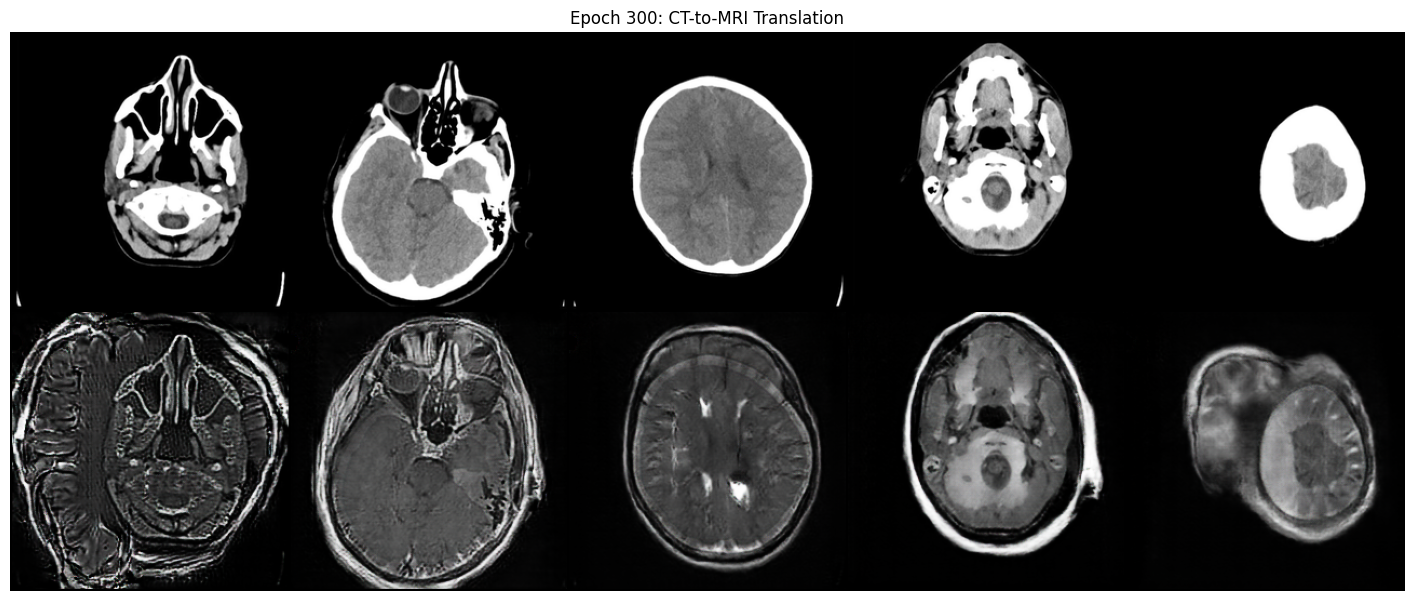

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300 - lr: 0.00000 - gen_loss: 2.59269 - disc_loss_MRI: 0.09842 - disc_loss_CT: 0.08340
Training ended.


In [19]:
dm = CustomDataModule(**DM_CONFIG)
model = CycleGAN(**MODEL_CONFIG)
trainer = L.Trainer(**TRAIN_CONFIG, default_root_dir=ckpt_folder)

trainer.fit(model, datamodule=dm)

In [20]:
model_path = glob.glob(os.path.join(f'{ckpt_folder}/checkpoints', "*.ckpt"))[0]
model_path

'/kaggle/working/unet_ct_mri/checkpoints/epoch=299-step=33000.ckpt'

In [21]:
model_eval = CycleGAN.load_from_checkpoint(model_path)

In [22]:
model_eval.eval()

CycleGAN(
  (gen_CT_MRI): UNetGenerator(
    (downsampling_path): Sequential(
      (0): Downsampling(
        (block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (1): Downsampling(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (2): Downsampling(
        (block): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): Downsampling(
        (block): Sequential(
      

In [23]:
gen_imgs = trainer.predict(model_eval, datamodule=dm)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Number of images generated: 744.


In [24]:
gen_imgs_list = [((img.float().squeeze().unsqueeze(0).unsqueeze(0)) * 0.5 + 0.5) for tensor in gen_imgs for img in tensor]

In [25]:
gen_imgs_catted = torch.cat(gen_imgs_list, dim=0)

In [26]:
real_imgs_list = [((img.float().squeeze().unsqueeze(0).unsqueeze(0)) * 0.5 + 0.5) for tensor in dm.predict_dataloader() for img in tensor]

In [27]:
real_imgs_catted = torch.cat(real_imgs_list, dim=0)

In [28]:
real_img_gen_img = torch.cat([real_imgs_catted, gen_imgs_catted], dim=1)

In [29]:
for idx, img in enumerate(real_img_gen_img, start=1):
    save_image(
        img,
        fp=f'{img_gen_foler}/real_img_gen_img_{idx}.png'
    )
print(f'Saved images')

Saved images


In [30]:
shutil.make_archive(main_folder, 'zip', main_folder)

'/kaggle/working/unet_ct_mri.zip'